# Tree boosting for conditional density estimation

Assume X and Y are both univariate

In [26]:
# load libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from sklearn.linear_model import LogisticRegression


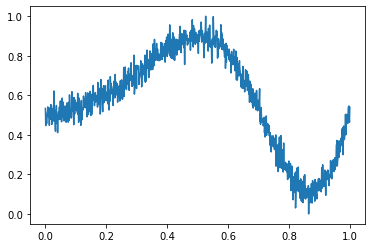

In [27]:
# simulate data
n = 1000
X = np.arange(start = 0, stop = 1, step = 1/n)
Y = np.random.default_rng().normal(0.0, 0.1, n) + np.sin(2 * np.pi * X**2)
Y = (Y - min(Y))/(max(Y) - min(Y))
plt.plot(X, Y);

1. initialization

In [28]:
K = 200
# residuals
r = np.zeros((K, n))
r[0, ] = Y
# F
treecdf_list = []
treecdf_list.append(lambda x: x)
# f (density)
pdf_list = []
pdf_list.append(lambda x: 1.0)


2. ensemble  

for (k in range(K)):
- Compute loss function
- Greedy: for given depth of the tree, choose the best split point that maximizes improvement in log likelihood (with logistic regression) by grid search
- Obtain the corresponding conditional tree treecdf in this iteration
- Update the current fit
- Update residuals
- Update density

functions needed: 
- input tree, evaluate treecdf and pdf (should be the same as in Naoki's paper)
- find the best split that maximizes improvement in avg log likelihood
- apply tree treecdf to points

In [29]:
class TreeNode:
    def __init__(self, left=None, right=None, split = None, pleft = None, left_bound = None, right_bound = None, theta = None):
        self.left = left
        self.right = right
        self.split = split
        self.pleft = pleft
        self.left_bound = left_bound
        self.right_bound = right_bound
        self.theta = theta
    def treecdf_A(self, x):
        if x <= self.left_bound or x > self.right_bound:
            return None
        mu_left = (self.split - self.left_bound) / (self.right_bound - self.left_bound)
        if not self.split or not self.pleft:
            return x
        if x <= self.split:
            return self.pleft/mu_left * (x - self.left_bound) + self.left_bound
        else:
            mu_right = 1 - mu_left
            return (1 - self.pleft)/mu_right * (x - self.right_bound) + self.right_bound
    def treecdf(self, x):
        if x <= self.left_bound or x > self.right_bound:
            return None
        if not self.left and not self.right:
            return self.treecdf_A(x)
        else:
            x_left, x_right = self.left.treecdf(x), self.right.treecdf(x)
            if x_left:
                x_new = x_left
            elif x_right:
                x_new = x_right
            else:
                return None
            return self.treecdf_A(x_new)
    def scalar_density(self, x):
        if not self.left and not self.right:
            return 1
        else:
            if x <= self.split:
                return self.pleft * self.left.scalar_density(x)
            else:
                return (1 - self.pleft) * self.right.scalar_density(x)
def make_copy(from_tree: TreeNode, to_tree: TreeNode):
        if not from_tree:
            return None
        to_tree.split = from_tree.split
        to_tree.pleft = from_tree.pleft
        to_tree.left_bound = from_tree.left_bound
        to_tree.right_bound = from_tree.right_bound
        to_tree.theta = from_tree.theta
        if from_tree.left:
            to_tree.left = TreeNode()
            # to_tree.left = make_copy(from_tree.left, to_tree.left)
            make_copy(from_tree.left, to_tree.left)
        if from_tree.right:
            to_tree.right = TreeNode()
            # to_tree.right = make_copy(from_tree.right, to_tree.right)
            make_copy(from_tree.right, to_tree.right)
        # return to_tree


A test case of tree treecdf (single tree)

In [30]:
# Xtest0 = np.concatenate([np.random.normal(0.0, 1, n), np.random.normal(10.0, 1, n)])
Xtest0 = np.random.normal(0.0, 1, n)
Xtest = (Xtest0 - min(Xtest0)) / (max(Xtest0) - min(Xtest0))

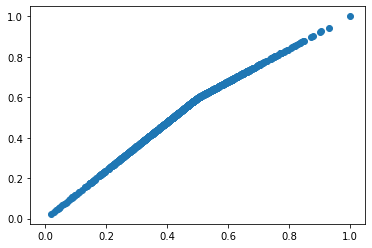

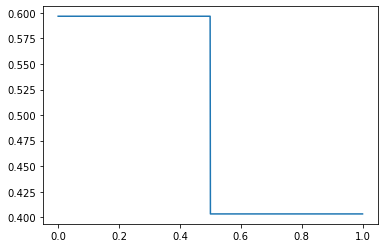

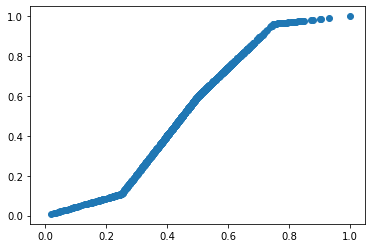

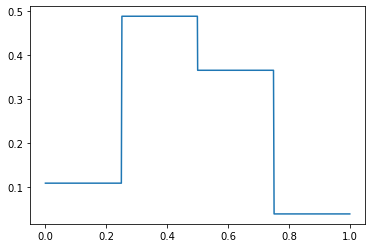

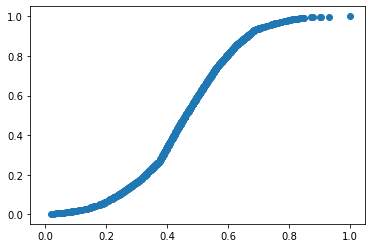

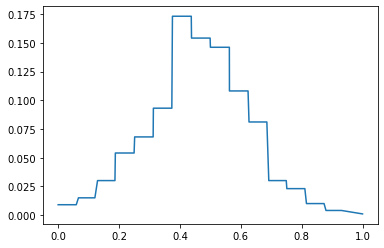

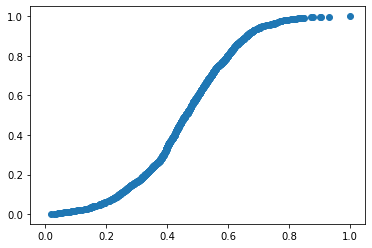

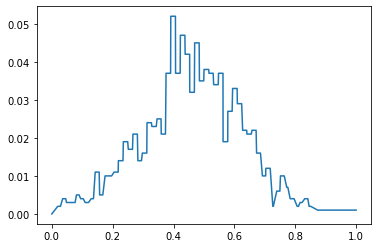

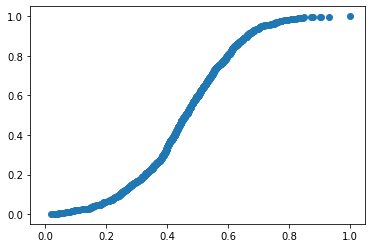

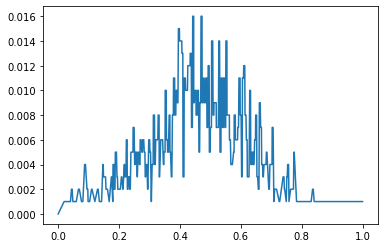

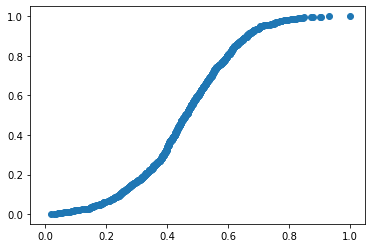

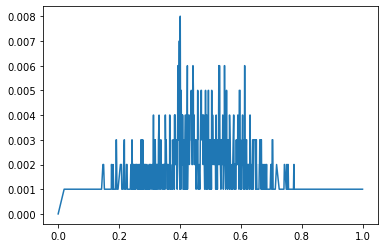

In [31]:
for max_depth in [1, 2, 4, 6, 8, 10]:
    tree = TreeNode(split = 0.5, left_bound=0, right_bound=1)
    curr_depth = 1
    # level traversal
    queue = [tree]
    while curr_depth <= max_depth and queue:
        l = len(queue)
        for i in range(l):
            node = queue.pop(0)
            if np.sum(np.logical_and(Xtest > node.left_bound, Xtest <= node.right_bound)) == 0:
                node.pleft = 0.5
            else:
                node.pleft = np.sum(np.logical_and(Xtest > node.left_bound, Xtest <= node.split)) / np.sum(np.logical_and(Xtest > node.left_bound, Xtest <= node.right_bound))
            node.left = TreeNode(split = (node.left_bound + node.split)/2, left_bound=node.left_bound, right_bound=node.split)
            node.right = TreeNode(split = (node.right_bound + node.split)/2, left_bound=node.split, right_bound=node.right_bound)
            queue.append(node.left)
            queue.append(node.right)
        curr_depth += 1
    x_trans = [tree.treecdf(x) for x in Xtest]
    x_density = [tree.scalar_density(x) for x in Xtest0]
    plt.figure()
    plt.scatter(Xtest, x_trans)
    # plt.scatter(Xtest, scipy.stats.norm.cdf(Xtest0));
    plt.figure()
    plt.plot(sorted(Xtest), ([tree.scalar_density(x) for x in sorted(Xtest)]));


fixed split & logistic regression, single tree

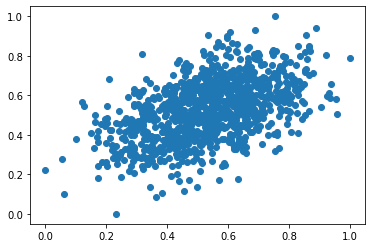

In [38]:
rho = 0.5
X = np.random.normal(0.0, 1, n)
Y = rho * X + np.sqrt(1 - rho**2) * np.random.normal(0.0, 1, n) 
X = (X - min(X))/(max(X) - min(X)) * 0.9999 + 0.00005
Y = (Y - min(Y))/(max(Y) - min(Y)) * 0.9999 + 0.00005
plt.scatter(X, Y);
Y0 = Y.copy()

In [33]:
# for max_depth in [1, 2, 4]:
#     tree = TreeNode(split = 0.5, left_bound=0, right_bound=1)
#     curr_depth = 1
#     # level traversal
#     queue = [tree]
#     while curr_depth <= max_depth and queue:
#         l = len(queue)
#         for i in range(l):
#             node = queue.pop(0)
#             if np.sum(np.logical_and(Y > node.left_bound, Y <= node.right_bound)) == 0:
#                 node.pleft = 0.5
#             elif np.sum(np.logical_and(Y > node.left_bound, Y <= node.split)) == 0:
#                 node.pleft = 0.0
#             elif np.sum(np.logical_and(Y > node.split, Y <= node.right_bound)) == 0:
#                 node.pleft = 1.0
#             else:
#                 model = LogisticRegression(solver='liblinear', random_state=0)
#                 local_index = np.logical_and(Y > node.left_bound, Y <= node.right_bound)
#                 y_local = Y[local_index]
#                 x_local = X[local_index]
#                 model.fit(x_local.reshape(-1, 1), (y_local > node.split).astype('int'))
#                 node.theta = [model.intercept_, model.coef_]
#                 # node.pleft = model.predict_proba(x_local)[:,0]
#             node.left = TreeNode(split = (node.left_bound + node.split)/2, left_bound=node.left_bound, right_bound=node.split)
#             node.right = TreeNode(split = (node.right_bound + node.split)/2, left_bound=node.split, right_bound=node.right_bound)
#             queue.append(node.left)
#             queue.append(node.right)
#         curr_depth += 1
#     # y_trans = [tree.treecdf(y) for y in Y]
#     # y_density = [tree.scalar_density(y) for y in Y]
#     # plt.figure()
#     # plt.scatter(Xtest, x_trans)
#     # plt.figure()
#     # plt.plot(sorted(Xtest), ([tree.scalar_density(x) for x in sorted(Xtest)]));


In [34]:
def helper(node, x):
    if not node or not node.theta:
        return None
    else:
        node.pleft = 1.0 / (1 + np.exp(node.theta[0][0] + x * node.theta[1][0][0]))
        helper(node.left, x)
        helper(node.right, x)

In [35]:
# res = []
# for i, x in enumerate(X):
#     tree_tmp = TreeNode()
#     make_copy(tree, tree_tmp)
#     helper(tree_tmp, x)
#     res.append(tree_tmp.treecdf(Y[i]))
    

In [36]:
# fig, ax = plt.subplots()
# ax.scatter(X, Y, label = '0');
# ax.scatter(X, np.array(res).reshape(len(res)), label = '1');
# ax.legend();

2nd iteration

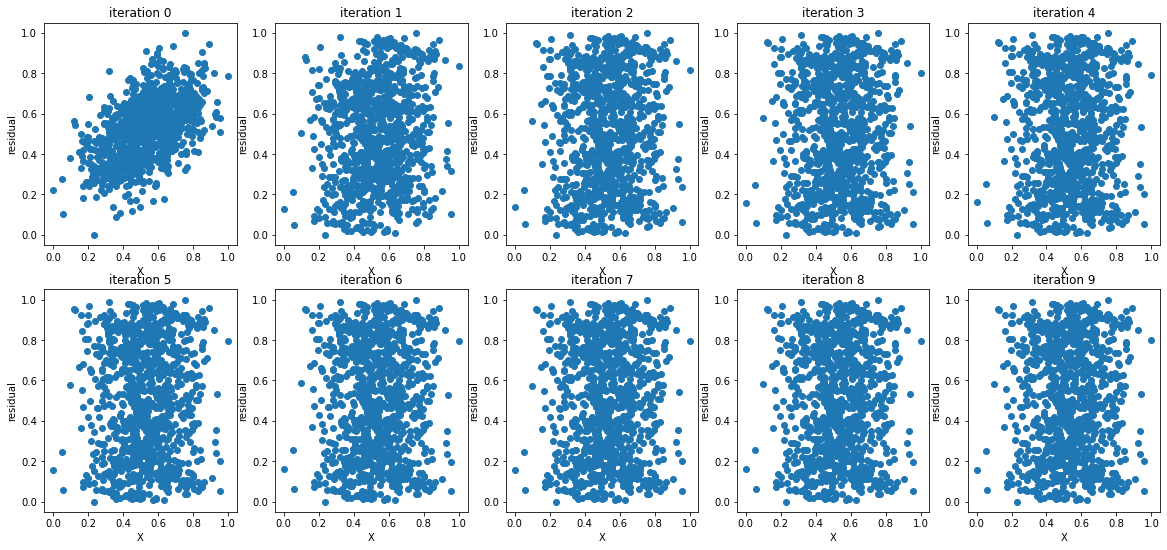

In [42]:
res = Y0.copy()
plt.figure(figsize=(20,9))
for iter in range(10): 
    plt.subplot(2, 5, iter + 1);
    plt.scatter(X, np.array(res).reshape(len(res)), label = iter);
    plt.title(f'iteration {iter}');
    plt.xlabel('X');
    plt.ylabel('residual');
    Y = np.array(res.copy())
    for max_depth in [2]:
        tree = TreeNode(split = 0.5, left_bound=0, right_bound=1)
        curr_depth = 1
        # level traversal
        queue = [tree]
        while curr_depth <= max_depth and queue:
            l = len(queue)
            for i in range(l):
                node = queue.pop(0)
                if np.sum(np.logical_and(Y > node.left_bound, Y <= node.right_bound)) == 0:
                    node.pleft = 0.5
                elif np.sum(np.logical_and(Y > node.left_bound, Y <= node.split)) == 0:
                    node.pleft = 0.0
                elif np.sum(np.logical_and(Y > node.split, Y <= node.right_bound)) == 0:
                    node.pleft = 1.0
                else:
                    model = LogisticRegression(solver='liblinear', random_state=0)
                    local_index = np.logical_and(Y > node.left_bound, Y <= node.right_bound)
                    y_local = Y[local_index]
                    x_local = X[local_index]
                    model.fit(x_local.reshape(-1, 1), (y_local > node.split).astype('int'))
                    node.theta = [model.intercept_, model.coef_]
                    # node.pleft = model.predict_proba(x_local)[:,0]
                node.left = TreeNode(split = (node.left_bound + node.split)/2, left_bound=node.left_bound, right_bound=node.split)
                node.right = TreeNode(split = (node.right_bound + node.split)/2, left_bound=node.split, right_bound=node.right_bound)
                queue.append(node.left)
                queue.append(node.right)
            curr_depth += 1
    res = []
    for i, x in enumerate(X):
        tree_tmp = TreeNode()
        make_copy(tree, tree_tmp)
        helper(tree_tmp, x)
        res.append(tree_tmp.treecdf(Y[i]))


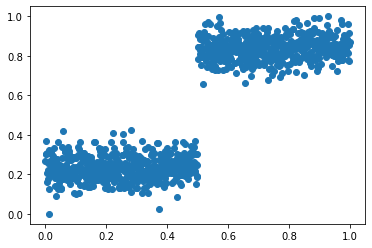

In [53]:
X = np.linspace(start = 0.001, stop = 0.999, num = n)
Y = (X > 0.5) + np.random.normal(0, 0.1, n) 
X = (X - min(X))/(max(X) - min(X)) * 0.9999 + 0.00005
Y = (Y - min(Y))/(max(Y) - min(Y)) * 0.9999 + 0.00005
plt.scatter(X, Y);
Y0 = Y.copy()

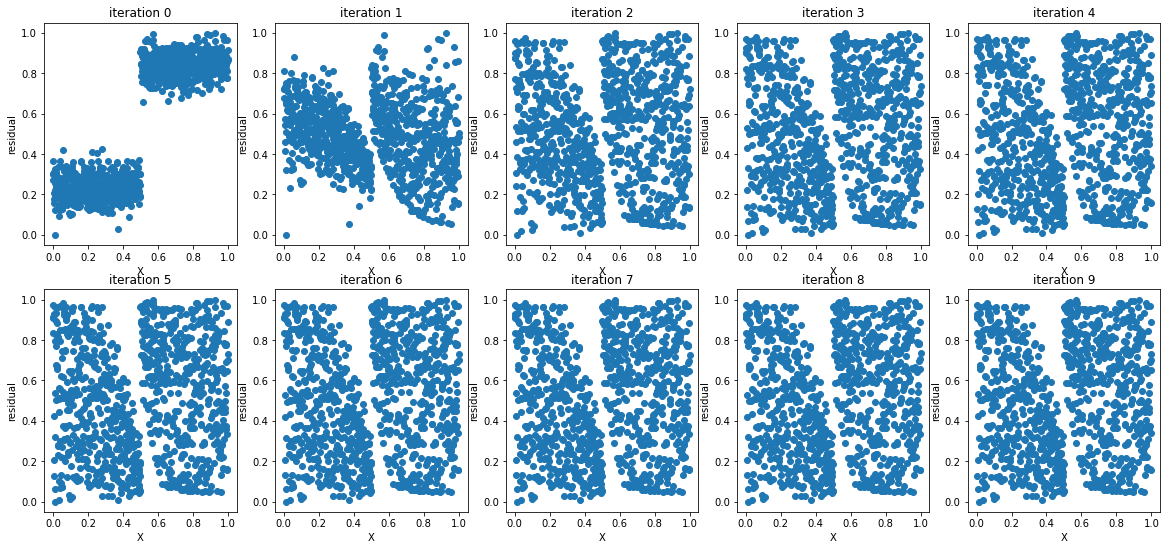

In [54]:
res = Y0.copy()
plt.figure(figsize=(20,9))
for iter in range(10): 
    plt.subplot(2, 5, iter + 1);
    plt.scatter(X, np.array(res).reshape(len(res)), label = iter);
    plt.title(f'iteration {iter}');
    plt.xlabel('X');
    plt.ylabel('residual');
    Y = np.array(res.copy())
    for max_depth in [2]:
        tree = TreeNode(split = 0.5, left_bound=0, right_bound=1)
        curr_depth = 1
        # level traversal
        queue = [tree]
        while curr_depth <= max_depth and queue:
            l = len(queue)
            for i in range(l):
                node = queue.pop(0)
                if np.sum(np.logical_and(Y > node.left_bound, Y <= node.right_bound)) == 0:
                    node.pleft = 0.5
                elif np.sum(np.logical_and(Y > node.left_bound, Y <= node.split)) == 0:
                    node.pleft = 0.0
                elif np.sum(np.logical_and(Y > node.split, Y <= node.right_bound)) == 0:
                    node.pleft = 1.0
                else:
                    model = LogisticRegression(solver='liblinear', random_state=0)
                    local_index = np.logical_and(Y > node.left_bound, Y <= node.right_bound)
                    y_local = Y[local_index]
                    x_local = X[local_index]
                    model.fit(x_local.reshape(-1, 1), (y_local > node.split).astype('int'))
                    node.theta = [model.intercept_, model.coef_]
                    # node.pleft = model.predict_proba(x_local)[:,0]
                node.left = TreeNode(split = (node.left_bound + node.split)/2, left_bound=node.left_bound, right_bound=node.split)
                node.right = TreeNode(split = (node.right_bound + node.split)/2, left_bound=node.split, right_bound=node.right_bound)
                queue.append(node.left)
                queue.append(node.right)
            curr_depth += 1
    res = []
    for i, x in enumerate(X):
        tree_tmp = TreeNode()
        make_copy(tree, tree_tmp)
        helper(tree_tmp, x)
        res.append(tree_tmp.treecdf(Y[i]))


**Monte Carlo samples from the additive model** 

grid search for partition point

How to fit logistic regression?

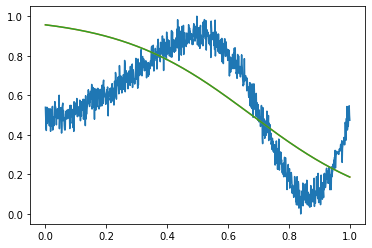

In [45]:
model = LogisticRegression(solver='liblinear', random_state=0)
model.fit(X.reshape(-1, 1), (Y > 0.5).astype('int'))
phat = model.predict_proba(X.reshape(-1, 1))[:,1]
plt.plot(X, Y);
plt.plot(X, phat);
plt.plot(X.reshape(1000), (np.exp(model.intercept_ + X * model.coef_) / (1+ np.exp(model.intercept_ + X * model.coef_))).reshape(1000))